In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
"""
Determine the WordNet part of speech tag for a given tag, useful during lemmatization.

"""

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [ ]:
"""
Clean and preprocess the text data by lowering case, removing punctuation,
numbers, specific words, and lemmatizing the text.

"""
def clean_text(text, min_length=3):
    if pd.isna(text) or len(text.strip()) < min_length:
        return None  
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'said', '', text)
    text = re.sub(r'would', '', text)
    
    text_tokens = word_tokenize(text)
    tagged_tokens = pos_tag(text_tokens)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens if word not in stop_words]
    
    return ' '.join(filtered_text) if len(filtered_text) >= min_length else None

In [ ]:
def load_data(topic):
    file_path = f'{topic}_data.csv'
    data = pd.read_csv(file_path)
    data['cleaned_content'] = data['Article Text'].apply(clean_text)
    failed_entries = data['cleaned_content'].str.contains('client error', na=False)
    cleaned_data = data[~failed_entries]
    print(f"Filtered out {failed_entries.sum()} failed entries.")
    return cleaned_data

In [ ]:
"""
Perform Latent Dirichlet Allocation (LDA) to model topics in the text data.
Returns a list of topics with their respective word distributions.

"""

def perform_lda(text_data):
    num_topics = 3  
    passes = 20    
    num_words = 10

    if not text_data:
        return []
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
    return lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)

In [ ]:
def generate_word_cloud(topics, stop_words):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        width=2500,
        height=1800,
        max_words=10,
        colormap='tab10',
        color_func=lambda *args, **kwargs: cols[i % len(cols)],
        prefer_horizontal=1.0
    )

    bias_categories = ['left', 'right', 'center']
    fig, axes = plt.subplots(len(bias_categories), len(topics), figsize=(15, 10))

    for i, bias in enumerate(bias_categories):
        for j, (topic_id, topic_words) in enumerate(topics):
            print(f"\nLDA Topics {j} for {bias.upper()} Bias:{topic_words}")
            topic_dict = dict(topic_words)
            
            cloud.generate_from_frequencies(topic_dict)
            ax = axes[i][j]  
            ax.imshow(cloud)
            ax.set_title(f'{bias.title()} Bias: Topic {topic_id}', fontdict=dict(size=16))
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def process_topic(topic, stop_words):
    print(f"Processing {topic}...")
    cleaned_data = load_data(topic)
    bias_categories = ['left', 'right', 'center']
    for bias in bias_categories:
        print(f"Processing bias: {bias}")
        subset_text_data = [text.split() if text is not None else [] for text in cleaned_data[cleaned_data['Bias Rating'] == bias]['cleaned_content']]
        lda_topics = perform_lda(subset_text_data)
        generate_word_cloud(lda_topics, stop_words)



LDA Topics 0 for LEFT Bias:[('health', 0.010103751), ('people', 0.009509103), ('insurance', 0.009023751), ('plan', 0.008280173), ('healthcare', 0.0077116727), ('care', 0.0065604607), ('bill', 0.005782659), ('house', 0.0055704415), ('work', 0.0054942286), ('system', 0.005483992)]

LDA Topics 1 for LEFT Bias:[('gaza', 0.029953482), ('israeli', 0.024673171), ('october', 0.020906266), ('israel', 0.018512918), ('image', 0.017172784), ('palestinian', 0.013344849), ('november', 0.011865676), ('hospital', 0.0069112265), ('people', 0.006682393), ('kill', 0.006641175)]

LDA Topics 2 for LEFT Bias:[('care', 0.012778336), ('trans', 0.011249308), ('state', 0.011130003), ('genderaffirming', 0.009261238), ('bill', 0.009014814), ('ban', 0.008780937), ('child', 0.00836541), ('law', 0.008035435), ('transgender', 0.0071431487), ('people', 0.0069496445)]

LDA Topics 0 for RIGHT Bias:[('people', 0.008914527), ('insurance', 0.008481547), ('plan', 0.008456492), ('healthcare', 0.007379407), ('health', 0.0072

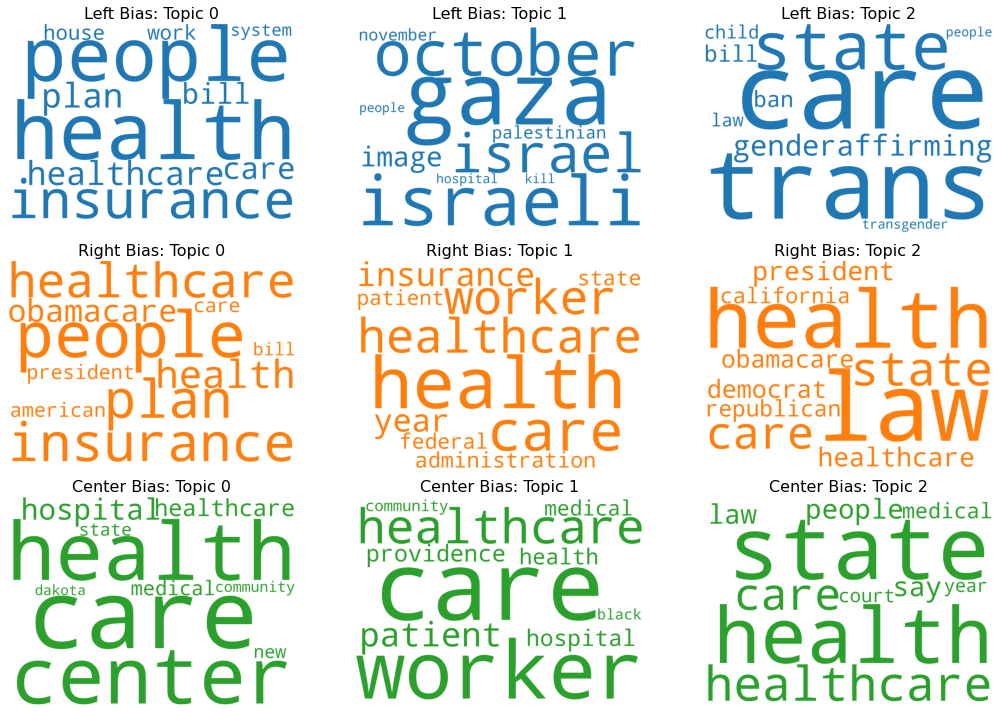

In [ ]:
stop_words = set(stopwords.words('english'))
process_topic('healthcare', stop_words)



LDA Topics 0 for LEFT Bias:[('state', 0.01765197), ('law', 0.014463783), ('texas', 0.014214348), ('federal', 0.0098477565), ('immigration', 0.009132134), ('court', 0.007693009), ('border', 0.007024159), ('florida', 0.006281352), ('desantis', 0.0060710716), ('u', 0.0052657267)]

LDA Topics 1 for LEFT Bias:[('border', 0.016137319), ('immigration', 0.012075707), ('u', 0.00843943), ('biden', 0.007863393), ('migrant', 0.0077081155), ('policy', 0.006759159), ('people', 0.006322943), ('country', 0.0059184427), ('state', 0.0059094033), ('trump', 0.0056993267)]

LDA Topics 2 for LEFT Bias:[('border', 0.01738714), ('trump', 0.009358656), ('republican', 0.008860049), ('u', 0.008616916), ('immigration', 0.008087028), ('migrant', 0.0076118186), ('bill', 0.007214292), ('house', 0.0068761124), ('biden', 0.006572781), ('new', 0.0054056984)]

LDA Topics 0 for RIGHT Bias:[('immigration', 0.014087849), ('immigrant', 0.0070542), ('american', 0.006448971), ('worker', 0.0052940655), ('policy', 0.0040236334

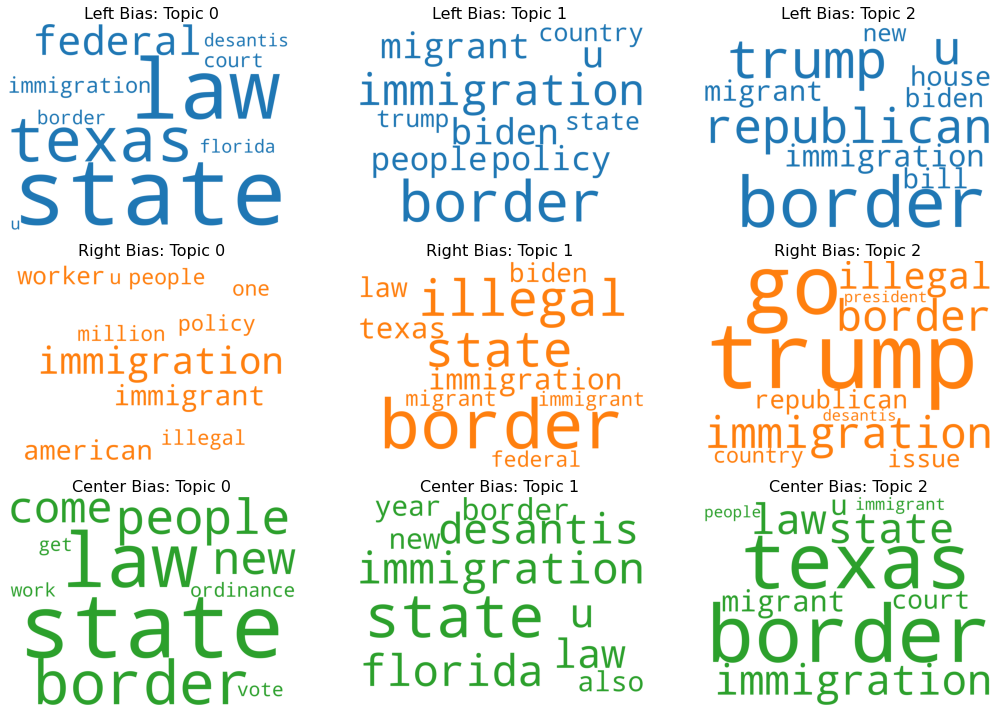

In [ ]:
process_topic('immigration', stop_words)



LDA Topics 0 for LEFT Bias:[('economy', 0.010059674), ('inflation', 0.008525888), ('year', 0.007879302), ('rate', 0.006548167), ('economic', 0.0060095014), ('recession', 0.0056348615), ('u', 0.0050527537), ('people', 0.004889919), ('business', 0.0047536967), ('fed', 0.004752854)]

LDA Topics 1 for LEFT Bias:[('job', 0.016989838), ('rate', 0.011870503), ('year', 0.009264487), ('month', 0.008277797), ('economy', 0.007731278), ('growth', 0.0070682485), ('price', 0.006808886), ('say', 0.0067426856), ('labor', 0.0065773665), ('market', 0.00623466)]

LDA Topics 2 for LEFT Bias:[('economy', 0.013447224), ('economic', 0.009475937), ('year', 0.008188457), ('president', 0.005360655), ('government', 0.0049722763), ('percent', 0.004836692), ('growth', 0.0048044138), ('tax', 0.004129744), ('american', 0.0041039335), ('country', 0.0038888329)]

LDA Topics 0 for RIGHT Bias:[('rate', 0.018090872), ('job', 0.014526366), ('inflation', 0.009749473), ('economy', 0.009322201), ('year', 0.008929892), ('gro

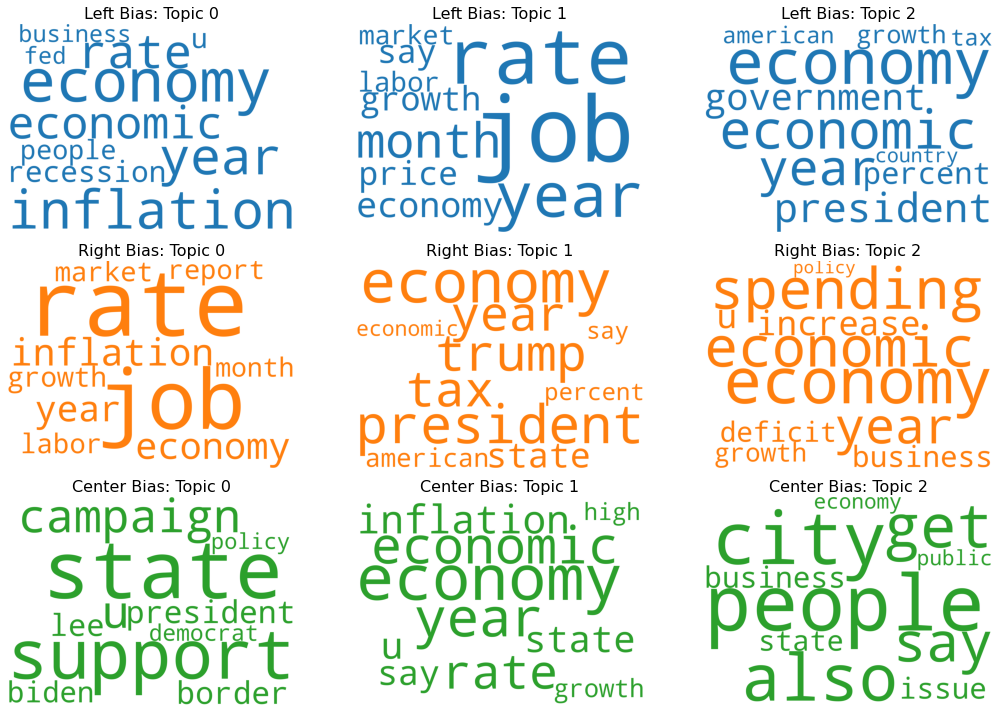

In [ ]:
process_topic('economy', stop_words)



LDA Topics 0 for LEFT Bias:[('abortion', 0.017065918), ('state', 0.014474736), ('republican', 0.010415499), ('right', 0.00757521), ('ban', 0.0065068617), ('voter', 0.0060619167), ('democrat', 0.0056160535), ('issue', 0.0056137466), ('law', 0.005350658), ('year', 0.005325532)]

LDA Topics 1 for LEFT Bias:[('abortion', 0.030248506), ('state', 0.014288865), ('ban', 0.011594023), ('law', 0.0064346544), ('clinic', 0.006074559), ('court', 0.005899949), ('year', 0.0057591195), ('right', 0.00551871), ('wisconsin', 0.0054596267), ('county', 0.0038440775)]

LDA Topics 2 for LEFT Bias:[('abortion', 0.031022944), ('state', 0.019603796), ('court', 0.012664586), ('right', 0.012338797), ('ban', 0.0080148075), ('law', 0.007123057), ('texas', 0.0070974687), ('ballot', 0.0067736134), ('cox', 0.006234256), ('pregnancy', 0.0059198774)]

LDA Topics 0 for RIGHT Bias:[('abortion', 0.02658537), ('state', 0.016067522), ('right', 0.010862198), ('ohio', 0.009146576), ('amendment', 0.00846001), ('issue', 0.00752

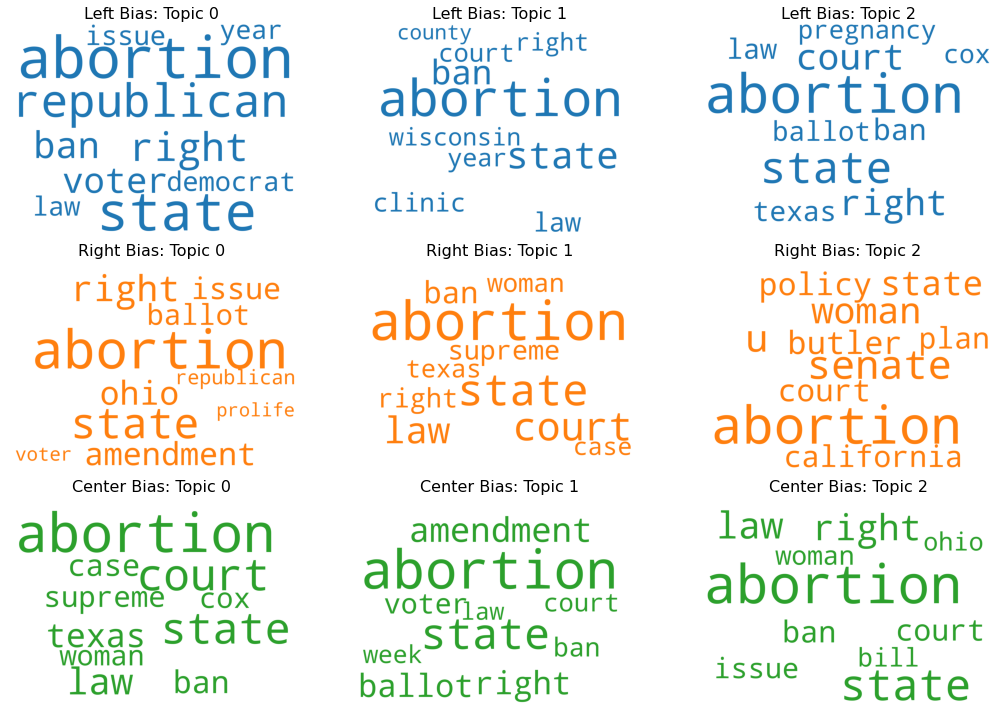

In [ ]:
process_topic('abortion', stop_words)
